In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [119]:
# CSV 파일 불러오기
df = pd.read_csv("/content/sample_data/BP_data.csv")
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [120]:
# 컬렴명 확인
df.columns

Index(['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders'],
      dtype='object')

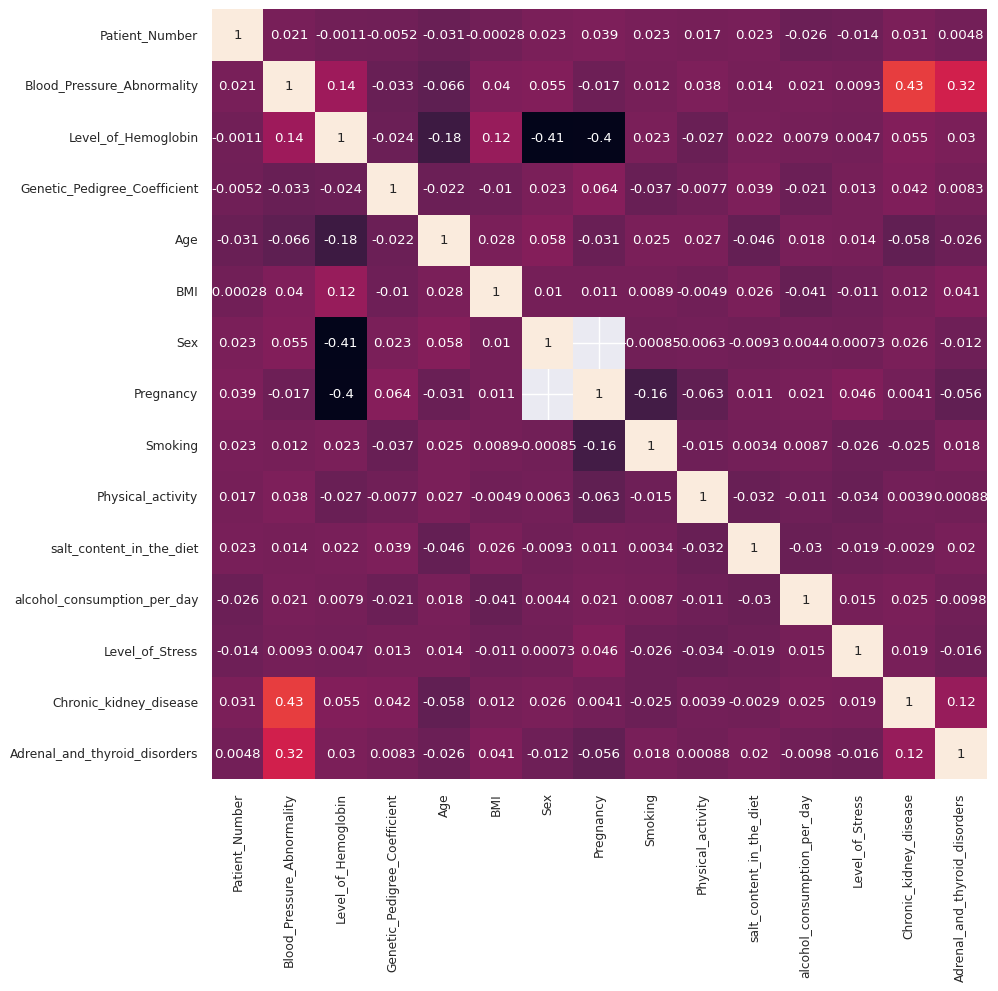

In [122]:
# HEATMAP
df_corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


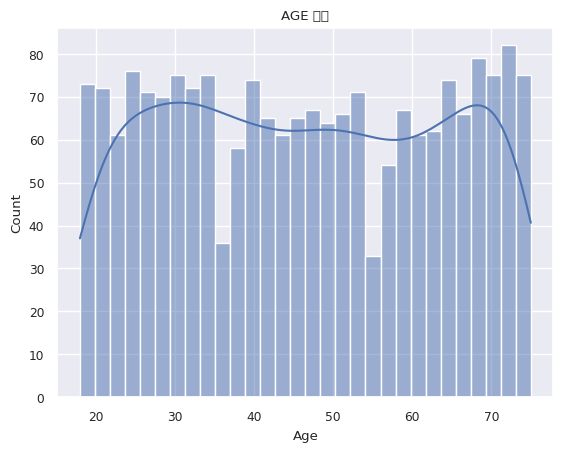

In [159]:
# HISTPLOT
# 데이터 분포의 균등함 확인
sns.histplot(data=df, x='Age', bins=30, kde=True)
plt.title('AGE 분포')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [ ]:
# SCATTERPLOT
# 두 연속적인 변수간의 상관관계 확인하기
sns.scatterplot(x='Chronic_kidney_disease', y='Blood_Pressure_Abnormality', data=df)
plt.title('Chronic_kidney_disease vs Blood_Pressure_Abnormality')
plt.xlabel('Blood_Pressure_Abnormality')
plt.ylabel('Chronic_kidney_disease')
plt.show()

In [121]:
print("결측치 확인:\n", df.isnull().sum())

결측치 확인:
 Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64


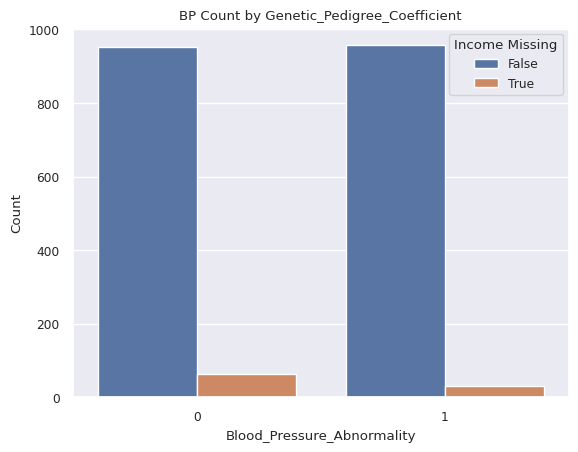

In [123]:
# COUNTPLOT
# 변수에 따른 TARGET의 상관관계 확인하기
import seaborn as sns
import matplotlib.pyplot as plt

df['income_missing'] = df['Genetic_Pedigree_Coefficient'].isna()
sns.countplot(x='Blood_Pressure_Abnormality', hue='income_missing', data=df)
plt.title('BP Count by Genetic_Pedigree_Coefficient')
plt.xlabel('Blood_Pressure_Abnormality')
plt.ylabel('Count')
plt.legend(title='Income Missing')
plt.show()

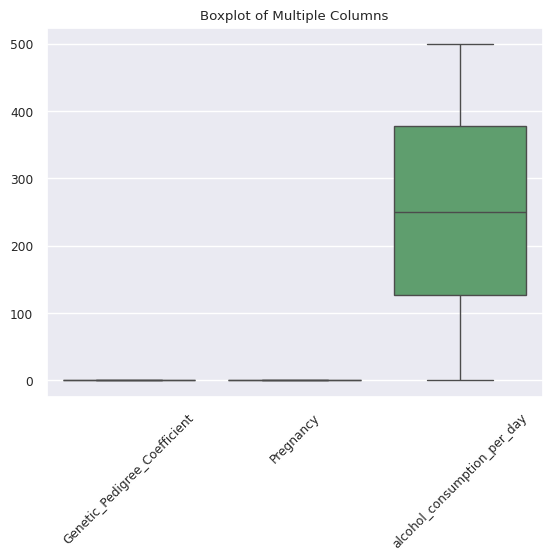

In [124]:
# BOXPLOT
# 결측치의 대체값을 찾기 위한 COLUMN의 범위 확인하기
sns.boxplot(data=df[['Genetic_Pedigree_Coefficient', 'Pregnancy', 'alcohol_consumption_per_day']])
plt.title('Boxplot of Multiple Columns')
plt.xticks(rotation=45)
plt.show()

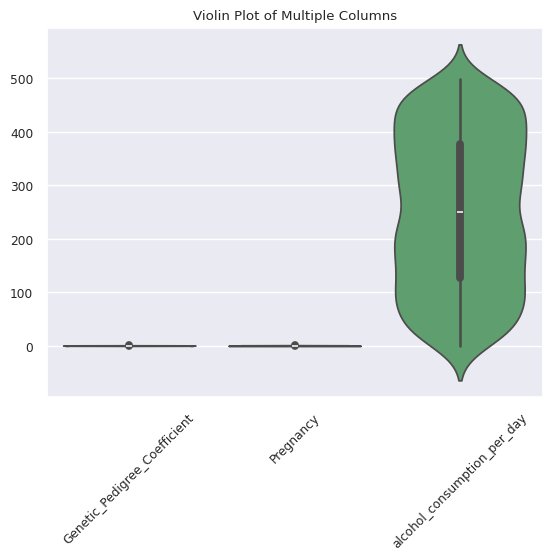

In [125]:
# VIOLINPLOT
# 커널 밀도 추정 (KDE)로 표시
sns.violinplot(data=df[['Genetic_Pedigree_Coefficient', 'Pregnancy', 'alcohol_consumption_per_day']])
plt.title('Violin Plot of Multiple Columns')
plt.xticks(rotation=45)
plt.show()

In [141]:
# 결측치 제거
df['Pregnancy'] = df['Pregnancy'].fillna(0)
df['Genetic_Pedigree_Coefficient'] = df['Genetic_Pedigree_Coefficient'].fillna(-1)
df['alcohol_consumption_per_day'] = df['alcohol_consumption_per_day'].fillna(-1)

df.isnull().sum()

,0
Patient_Number,0
Blood_Pressure_Abnormality,0
Level_of_Hemoglobin,0
Genetic_Pedigree_Coefficient,0
Age,0
BMI,0
Sex,0
Pregnancy,0
Smoking,0
Physical_activity,0


In [146]:
# 1. 데이터 전처리 (X: 특성, y: 타겟)
X = df.drop(['Blood_Pressure_Abnormality', 'income_missing'], axis=1).values
y = df['Blood_Pressure_Abnormality'].values
print(X)
print(y)

[[1.000e+00 1.128e+01 9.000e-01 ... 2.000e+00 1.000e+00 1.000e+00]
 [2.000e+00 9.750e+00 2.300e-01 ... 3.000e+00 0.000e+00 0.000e+00]
 [3.000e+00 1.079e+01 9.100e-01 ... 2.000e+00 1.000e+00 0.000e+00]
 ...
 [1.998e+03 1.691e+01 2.200e-01 ... 2.000e+00 1.000e+00 1.000e+00]
 [1.999e+03 1.115e+01 7.200e-01 ... 3.000e+00 0.000e+00 1.000e+00]
 [2.000e+03 1.136e+01 9.000e-02 ... 1.000e+00 1.000e+00 0.000e+00]]
[1 0 1 ... 1 0 1]


In [148]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)

[[-1.731185   -0.19670848  1.11955863 ... -0.01517697  0.9900495
   1.12017473]
 [-1.72945295 -0.89656771 -0.4631235  ...  1.19898069 -1.0100505
  -0.89271787]
 [-1.7277209  -0.4208464   1.14318075 ... -0.01517697  0.9900495
  -0.89271787]
 ...
 [ 1.7277209   2.37859055 -0.48674562 ... -0.01517697  0.9900495
   1.12017473]
 [ 1.72945295 -0.25617364  0.69436045 ...  1.19898069 -1.0100505
   1.12017473]
 [ 1.731185   -0.16011453 -0.7938332  ... -1.22933464  0.9900495
  -0.89271787]]


In [149]:
# 3. 데이터 분할 (훈련 80%, 테스트 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("data SHAPE :")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

data SHAPE :
(1600, 14) (1600,)
(400, 14) (400,)


In [150]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 14]),
 torch.Size([400, 14]),
 torch.Size([1600]),
 torch.Size([400]))

In [153]:
class BP_Dense(nn.Module):
    def __init__(self):
        super(BP_Dense, self).__init__()
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)
        self.fc4 = nn.Linear(4, 1)  # 1 class in the dataset

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model, loss function, and optimizer
model = BP_Dense()

In [154]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [155]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        labels = labels.view(-1, 1).float()
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            labels = labels.view(-1, 1).float()
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/25, Loss: 0.6854, Accuracy: 75.25%
Epoch 2/25, Loss: 0.6171, Accuracy: 76.75%
Epoch 3/25, Loss: 0.5346, Accuracy: 74.75%
Epoch 4/25, Loss: 0.5107, Accuracy: 74.75%
Epoch 5/25, Loss: 0.4938, Accuracy: 76.50%
Epoch 6/25, Loss: 0.4779, Accuracy: 77.00%
Epoch 7/25, Loss: 0.4645, Accuracy: 80.75%
Epoch 8/25, Loss: 0.4513, Accuracy: 77.50%
Epoch 9/25, Loss: 0.4357, Accuracy: 78.25%
Epoch 10/25, Loss: 0.4239, Accuracy: 79.75%
Epoch 11/25, Loss: 0.4129, Accuracy: 78.50%
Epoch 12/25, Loss: 0.3934, Accuracy: 80.75%
Epoch 13/25, Loss: 0.3748, Accuracy: 81.75%
Epoch 14/25, Loss: 0.3542, Accuracy: 82.50%
Epoch 15/25, Loss: 0.3349, Accuracy: 84.25%
Epoch 16/25, Loss: 0.3197, Accuracy: 84.25%
Epoch 17/25, Loss: 0.2992, Accuracy: 85.50%
Epoch 18/25, Loss: 0.2942, Accuracy: 85.25%
Epoch 19/25, Loss: 0.2851, Accuracy: 85.50%
Epoch 20/25, Loss: 0.2786, Accuracy: 85.75%
Epoch 21/25, Loss: 0.2686, Accuracy: 86.00%
Epoch 22/25, Loss: 0.2656, Accuracy: 85.25%
Epoch 23/25, Loss: 0.2609, Accuracy: 86.7

In [156]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[195  28]
 [ 26 151]]
F1 Score: 0.87
Precision: 0.87
Recall: 0.86
Specificity: 0.86


In [157]:
print(outputs[:10])

tensor([[0.0040],
        [0.0571],
        [0.0033],
        [0.0311],
        [0.0065],
        [0.9990],
        [0.2713],
        [0.0245],
        [0.2132],
        [0.0387]])


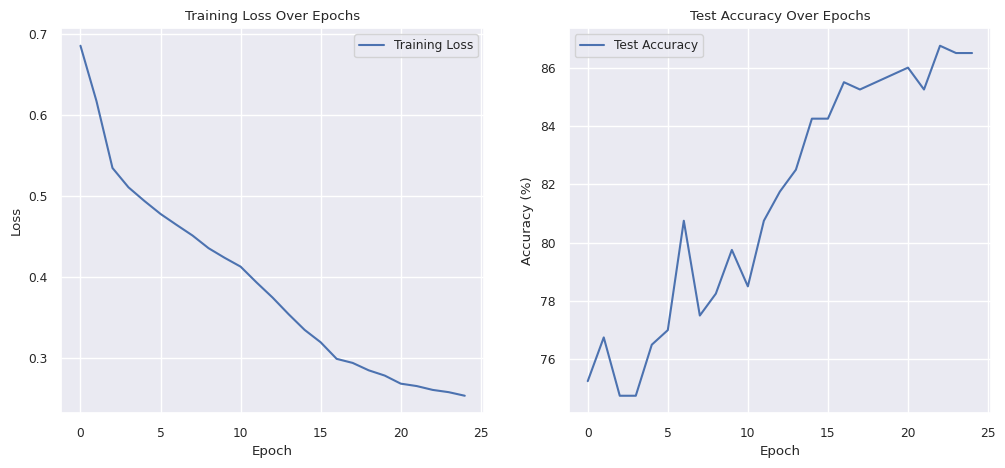

In [158]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()